# Title

# Description

In [1]:
# pip install category_encoders
# !pip install pmdarima

# Importation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
import os
warnings.filterwarnings("ignore")

# Data Loading

In [49]:
train = pd.read_csv('../../assets/data/Train.csv')
sample = pd.read_csv('../../assets/data/SampleSubmission.csv')

# Dataset overview

In [50]:
train.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


In [51]:
train.drop('ID', axis=1, inplace=True)

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289926 entries, 0 to 289925
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   impressions         289526 non-null  float64
 1   clicks              289526 non-null  float64
 2   cost                289526 non-null  float64
 3   conversions         289526 non-null  float64
 4   ad_type             289526 non-null  object 
 5   currency            289526 non-null  object 
 6   ID                  289926 non-null  object 
 7   date                289926 non-null  object 
 8   call_type           36900 non-null   object 
 9   call_status         36900 non-null   object 
 10  start_time          36900 non-null   object 
 11  duration            36900 non-null   float64
 12  end_time            36900 non-null   object 
 13  display_location    36900 non-null   object 
 14  impression_share    289926 non-null  float64
 15  conversions_calls   280071 non-nul

In [53]:
train.describe()

,impressions,clicks,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
count,289526.000000,289526.000000,289526.000000,289526.000000,36900.000000,289926.000000,280071.000000,289526.000000,289526.000000,289526.000000
mean,72.809620,8.039927,2208.525051,0.790140,67.968970,16.656556,0.127928,2.745584,2.879824,10.706165
std,153.592792,36.241161,7392.609733,10.298258,98.055148,12.186418,0.526362,1.571108,1.670356,4.509450
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,9.990000,0.000000,2.000000,1.000000,10.000000
50%,23.000000,2.000000,553.000000,0.000000,36.000000,11.421975,0.000000,3.000000,3.000000,12.000000
75%,69.000000,6.000000,2062.500000,0.000000,95.000000,20.122939,0.000000,4.000000,4.000000,14.000000
max,6833.000000,4227.000000,719928.000000,1297.000000,2125.000000,100.000000,8.000000,7.000000,7.000000,20.000000


In [54]:
numeric_columns = train.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
categoric_columns = [col for col in train.columns if col not in numeric_columns]
categoric_columns.remove('date')

In [55]:
for col in categoric_columns:
  print(col, len(train[col].unique()), train[col].unique())

ad_type 4 ['EXPANDED_TEXT_AD' 'EXPANDED_DYNAMIC_SEARCH_AD' 'RESPONSIVE_SEARCH_AD'
 nan]
currency 3 ['ZAR' 'USD' nan]
ID 185 ['ID_5da86e71bf5dee4cf5047046' 'ID_5e43c29e6279884e2827d894'
 'ID_5e4e7b480e374330ee151305' 'ID_5e8ad56cd4090270567b6c58'
 'ID_5e8b4f12d8709943490cd775' 'ID_5ebe73c4beb2212d415f6e56'
 'ID_5ee74f25f865a8154966b412' 'ID_5eebc5be7bcfa265595eb987'
 'ID_5f2ac3529666de2cdf5ae855' 'ID_5f3cdce8c0440e2c5902dd59'
 'ID_5f436d32c620230547446af4' 'ID_5f439a30fcc0f575b674bb95'
 'ID_5f4514323f494e4a2a5eb273' 'ID_5f9e5f1c691b48189c22aac6'
 'ID_5fa3dab4394cd16b000ec5fc' 'ID_5fc1263767e20c14590941ed'
 'ID_5fd88b10425b32098417a3d4' 'ID_600d8eaaf5c7660c0b1f0773'
 'ID_6017e410f7384a78e600da18' 'ID_602b729b3f4128452c1c2f64'
 'ID_602cfab1d7768d79aa6629b4' 'ID_604752a9861a02467a27c054'
 'ID_60475eaac98ea30d727b7385' 'ID_6047b0d4c59eff5af82a57ee'
 'ID_606f34aef59df516866d0ab1' 'ID_6083bd8472c70c3d1869bc68'
 'ID_608a6897d96a507cd36c935d' 'ID_608a6ad834a94a4eb8742899'
 'ID_60e556f789173d61d

## Hypothesis
**H0**: 

**H1**: 

## Questions

1. Is the train data complete?
2. Do we have seasonality in our ?
3. Are there outliers in our dataset?
4. What is the difference between RMSLE, RMSE and MSE?

| Issues                                  | how we intend to solve them                                                                                                   |
|----------------------------------------|------------------------------------------------------------------------------------------------------------|
| 1. date, start and end time column has wrong data type | convert to datetime                                            |
| 2. display_location has 'Ad' & 'AD' which are the same thing  | replace all 'Ad' with 'AD'                         |
| 2. issue 2 | soln2                         |


# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis.

## Fixing our issues

1. date column has wrong data type

In [10]:
train['date'] = pd.to_datetime(train['date'])

In [11]:
train['start_time'] = pd.to_datetime(train['start_time'], format='ISO8601')
train['end_time'] = pd.to_datetime(train['end_time'], format='ISO8601')

2. display_location column in train has values of 'Ad' & 'AD' which are the same thing  | replace all 'Ad' with 'AD' 

In [12]:
train['display_location'] = train['display_location'].replace('Ad', 'AD')

In [13]:
# make sure sorted by date
train = train.sort_values('date')

In [14]:
# create a function to check for missing extracted dates
def get_missing_dates(df):
  col = df.date
  missing_dates = (pd.date_range(

      start=col.min(), #start date
      end=col.max())   #end_date
      .difference(col))
  print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
  print(f"start: {col.min()}, end: {col.max()}")
  return missing_dates
get_missing_dates(train)

we have 0 dates missing out of 289926
start: 2020-01-01 00:00:00, end: 2024-02-13 00:00:00


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

## Drop Duplicates

In [15]:
train.drop_duplicates(inplace=True)

## Impute Missing Values

In [16]:
print(train.isnull().sum())

impressions              310
clicks                   310
cost                     310
conversions              310
ad_type                  310
currency                 310
date                       0
call_type             252418
call_status           252418
start_time            252418
duration              252418
end_time              252418
display_location      252418
impression_share           0
conversions_calls       9783
headline1_len            310
headline2_len            310
ad_description_len       310
dtype: int64


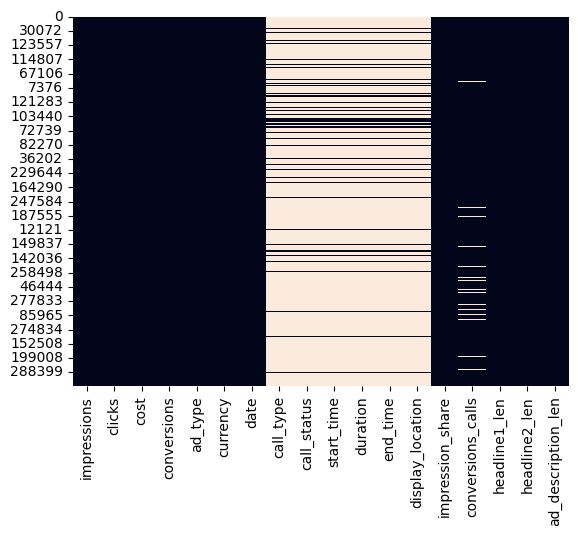

In [17]:
sns.heatmap(train.isnull(), cbar=False)
plt.show()

In [18]:
train = train.fillna(method='ffill')
train = train.fillna(method='bfill')

In [19]:
# train = train.interpolate(method ='linear') # limit_direction : {‘forward’, ‘backward’, ‘both’},
# train = train.interpolate(method ='time')
# train = train.interpolate(method ='slinear')
# train = train.interpolate(method ='spline')

# Exploratory Data Analysis: EDA

## Hypothesis Validation
**H0**: 

**H1**: 

## Answering Questions

2. Do we have seasonality in our sales?

In [20]:
# Assuming your time series data is stored in the variable 'sales_data'
sales_data = train['clicks']

In [21]:
# Perform KPSS test
kpss_result = kpss(sales_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

In [22]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 14.674894011753178
p-value: 0.01


stationary if p-value > 0.05

series is stationary since 0.01 < 0.05

### Checking for Stationarity of the Train Dataset

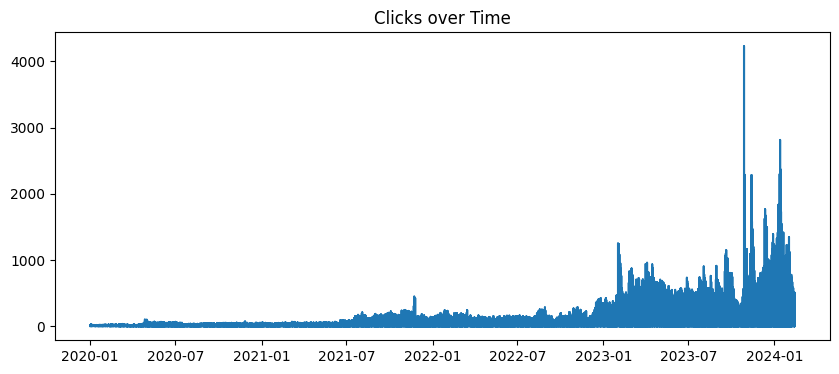

In [23]:
# Plot the series
plt.figure(figsize=(10,4))
plt.plot(train.set_index('date')['clicks'], linestyle='-')

plt.title('Clicks over Time')
# Show plot
plt.show()

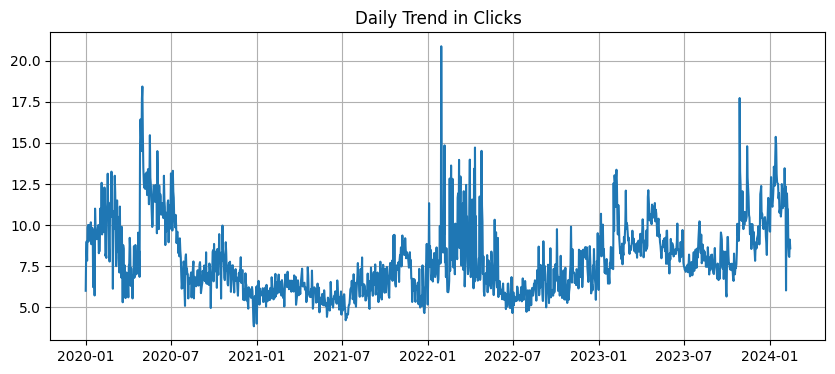

In [24]:
# Resample to monthly data and calculate the mean clicks per month
train_resampled = train.resample('D', on='date')['clicks'].mean()

# Plot the time series
plt.figure(figsize=(10, 4))
plt.plot(train_resampled, linestyle='-')  # Plot the resampled monthly clicks

# Add a title
plt.title('Daily Trend in Clicks')

# Show the plot
plt.grid(True)
plt.show()


there is no trend in our series

3. Are there outliers in our dataset?

4. What is the difference between RMSLE, RMSE and MSE?

## Univariate Analysis

## Bivariate Analysis

In [25]:
# Calculate the correlation matrix
correlation_matrix = train[numeric_columns].corr()

# Find the moderately correlated variables
moderate_correlation = (correlation_matrix.abs() > 0.5) & (correlation_matrix != 1) & (correlation_matrix <0.8)

# Get the variable pairs with moderate correlation
moderate_correlation_pairs = [(i, j) for i in moderate_correlation.columns for j in moderate_correlation.columns if moderate_correlation.loc[i, j]]

# Print the moderately correlated variables
for pair in moderate_correlation_pairs:
    var1, var2 = pair
    correlation_value = correlation_matrix.loc[var1, var2]
    print(f"{var1} and {var2} are moderately correlated (correlation value: {correlation_value})")

impressions and clicks are moderately correlated (correlation value: 0.7346516246595252)
clicks and impressions are moderately correlated (correlation value: 0.7346516246595252)
headline1_len and ad_description_len are moderately correlated (correlation value: 0.5818840156235124)
headline2_len and ad_description_len are moderately correlated (correlation value: 0.550397267434298)
ad_description_len and headline1_len are moderately correlated (correlation value: 0.5818840156235124)
ad_description_len and headline2_len are moderately correlated (correlation value: 0.550397267434298)


# Feature Engineering

## Creating New Features

In [26]:
# time since previous ad_secs
# ad_duration_secs 
# start_time_secs, end_time_secs

## Features Encoding & scaling

In [27]:
train.set_index('date', inplace=True)

In [28]:
for col in categoric_columns:
  print(col, len(train[col].unique()), train[col].unique())

ad_type 3 ['EXPANDED_TEXT_AD' 'EXPANDED_DYNAMIC_SEARCH_AD' 'RESPONSIVE_SEARCH_AD']
currency 2 ['ZAR' 'USD']
call_type 2 ['Mobile click-to-call' 'Manually dialed']
call_status 2 ['Missed' 'Received']
display_location 3 ['AD' 'Website' 'LANDING_PAGE']


In [29]:
train['call_status'] = train['call_status'].map({'Missed': 0, 'Received': 1})

In [30]:
categoric_columns.remove('call_status')
numeric_columns.remove('clicks')

In [31]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.set_output(transform="pandas")
scaler = StandardScaler().set_output(transform="pandas")

In [32]:
scaled_num = scaler.fit_transform(train[numeric_columns])
encoded_cat = encoder.fit_transform(train[categoric_columns])

In [33]:
train = pd.concat([scaled_num, encoded_cat, train['call_status'], train['clicks']], axis=1)

## Resampling

In [34]:
# resampled = train.resample('D').sum()
# # train = resampled

**dataframe for the traditional time series models**

In [35]:
# train1 = train[['target']].copy()

In [36]:
# train1.head()

In [37]:
test, train_df  = train[len(train)-4000:], train[:len(train)-4000]
test.reset_index().date.min() # 2024-01-30

Timestamp('2024-01-31 00:00:00')

In [38]:
eval, train  = train_df[len(train_df)-4000:], train_df[:len(train_df)-4000]
eval.reset_index().date.min() # 2024-01-30

Timestamp('2024-01-18 00:00:00')

In [39]:
# Split data into parts
X_train, X_test, y_train, y_test = train.drop(['clicks'], axis=1), eval.drop(['clicks'], axis=1), train['clicks'], eval['clicks']

# Machine Learning Modeling

# Non-Traditional Time Series Models

### DecisionTreeRegressor

In [40]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

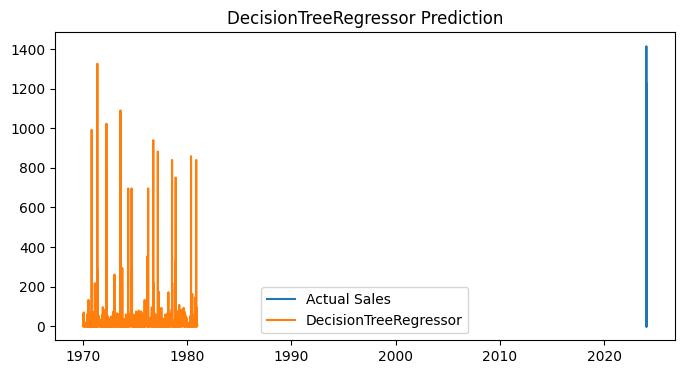

In [41]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [42]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

### KNN

In [43]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

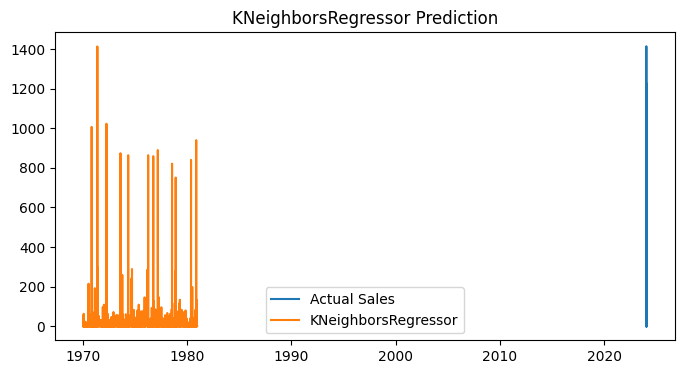

In [44]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(neigh_pred, label='KNeighborsRegressor')
plt.legend(loc='best')
plt.title('KNeighborsRegressor Prediction')
plt.show()

In [46]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# Concatenating the two DataFrames
results = pd.concat([results, model_results], ignore_index=True)

### RandomForestRegressor

In [48]:
from sklearn.ensemble import RandomForestRegressor
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor()
model_forest = forest.fit(X_train, y_train)

# Make predictions on X_test
forest_pred = model_forest.predict(X_test)

KeyboardInterrupt: 

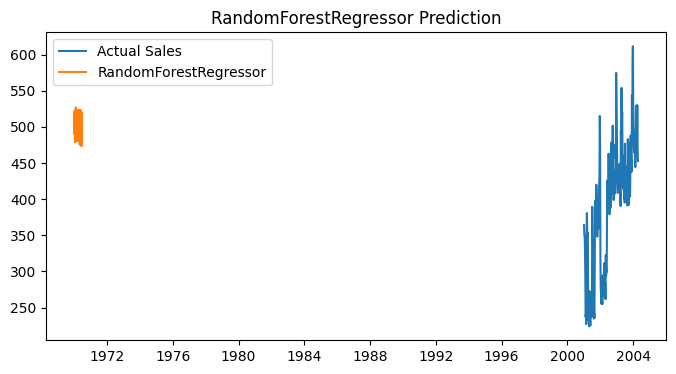

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(forest_pred, label='RandomForestRegressor')
plt.legend(loc='best')
plt.title('RandomForestRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, forest_pred)
msle = mean_squared_log_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Append the results to the DataFrame
model_results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

### Support Vector Regression (SVR)

In [ ]:
from sklearn.svm import SVR

# Initialize and fit the SVR model
svr = SVR()
model_svr = svr.fit(X_train, y_train)

# Make predictions on X_test
svr_pred = model_svr.predict(X_test)

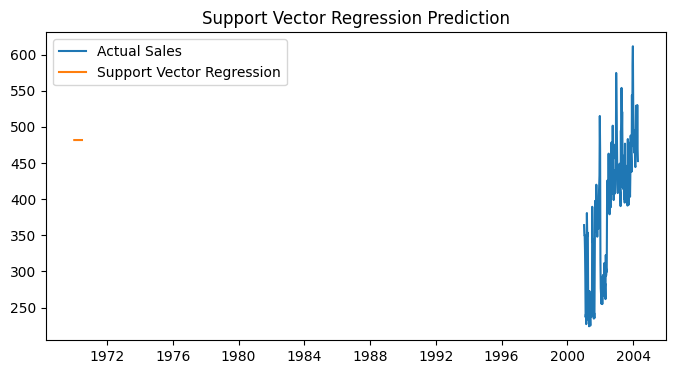

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(svr_pred, label='Support Vector Regression')
plt.legend(loc='best')
plt.title('Support Vector Regression Prediction')
plt.show()

In [ ]:
# Append the results to the DataFrame
mse = mean_squared_error(y_test, svr_pred)
msle = mean_squared_log_error(y_test, svr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['SVR', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and fit the Gradient Boosting model
gbr = GradientBoostingRegressor()
model_gbr = gbr.fit(X_train, y_train)

# Make predictions on X_test
gbr_pred = model_gbr.predict(X_test)

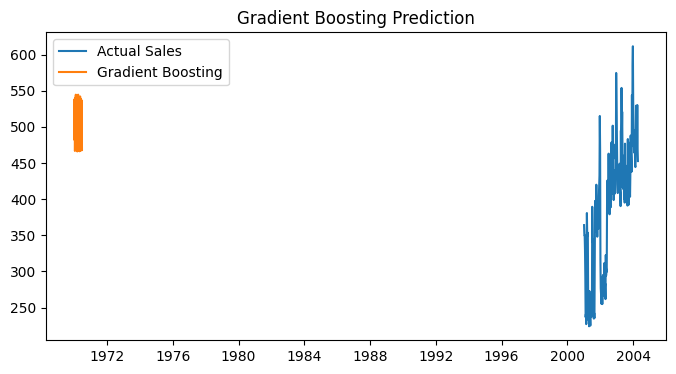

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(gbr_pred, label='Gradient Boosting')
plt.legend(loc='best')
plt.title('Gradient Boosting Prediction')
plt.show()

In [ ]:
# Append the results to the DataFrame
mse = mean_squared_error(y_test, gbr_pred)
msle = mean_squared_log_error(y_test, gbr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['Gradient Boosting', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

### XGBoost

In [ ]:
import xgboost as xgb

# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
model_xgboost = xgboost.fit(X_train, y_train)

# Make predictions on X_test
xgboost_pred = model_xgboost.predict(X_test)

# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgboost_pred)
msle = mean_squared_log_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and fit the Linear Regression model
linear_reg = LinearRegression()
model_linear_reg = linear_reg.fit(X_train, y_train)

# Make predictions on X_test
linear_reg_pred = model_linear_reg.predict(X_test)

# Append the results to the DataFrame
mse = mean_squared_error(y_test, linear_reg_pred)
msle = mean_squared_log_error(y_test, linear_reg_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['Linear Regression', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

## Models Comparison

In [ ]:
results

,Model,MSE,MSLE,RMSE,RMSLE
0,DecisionTree,17878.36,0.12,133.71,0.35
1,KNN,15157.08,0.11,123.11,0.33
2,Random Forest,18626.54,0.13,136.48,0.36
3,SVR,16025.20,0.11,126.59,0.34
4,Gradient Boosting,18096.48,0.12,134.52,0.35
5,XGBoost,21284.22,0.14,145.89,0.37
6,Linear Regression,1043641.46,1.65,1021.59,1.28


## Model Evaluation (Backtests)

In [ ]:
# Backtests with KNN
scores = {}

for idx, period in enumerate(backtests):

    _train = train.reset_index()[train.reset_index()['date_extracted'] < backtests[period][0]]
    _test = train.reset_index()[(train.reset_index()['date_extracted'] >= backtests[period][0]) & (train.reset_index()['date_extracted'] <= backtests[period][1])]

    Xtrain, ytrain = _train.set_index(['date_extracted']).drop(columns=['target']), _train.target
    Xtest, ytest = _test.set_index(['date_extracted']).drop(columns=['target']), _test.target

    knn_model = KNeighborsRegressor(n_neighbors=1).fit(Xtrain, ytrain)

    ypred = knn_model.predict(Xtest)

    scores[period] = np.sqrt(mean_squared_error(ytest, ypred))

print(scores)

{1: 34.064549640660424, 2: 34.40116704057176, 3: 44.942359839847455}


# Hyperparameter Tuning

### predicting sales in our test

In [ ]:
test_pred = neigh.predict(test)
test_pred

array([487.34998378, 487.34998378, 487.34998378, 487.34998378,
       487.34998378, 487.34998378, 487.34998378, 487.34998378,
       487.34998378])

In [ ]:
test.head()

,onpromotion,is_holiday,year,month,dayofmonth,dayofweek,dayofyear,weekofyear,quarter,is_month_start,...,cluster_1,cluster_2,cluster_3,cluster_4,holiday_type_0,holiday_type_1,holiday_type_2,season_0,season_1,season_2
date_extracted,,,,,,,,,,,,,,,,,,,,,
2004-06-20,6.59,0.00,4.00,6.00,19.50,0.50,170.50,25.00,2.00,0.00,...,0.43,0.37,0.48,0.57,0.00,1.00,0.00,0.00,1.00,1.00
2004-06-27,8.01,0.29,4.00,6.00,24.00,3.00,175.00,25.29,2.00,0.00,...,0.43,0.37,0.48,0.57,0.00,0.71,0.29,0.00,1.00,1.00
2004-07-04,8.49,0.14,4.00,6.57,13.86,3.00,182.00,26.29,2.57,0.14,...,0.43,0.37,0.48,0.57,0.00,0.86,0.14,0.00,1.00,1.00
2004-07-11,8.75,0.00,4.00,7.00,8.00,3.00,189.00,27.29,3.00,0.00,...,0.43,0.37,0.48,0.57,0.00,1.00,0.00,0.00,1.00,1.00
2004-07-18,7.33,0.00,4.00,7.00,15.00,3.00,196.00,28.29,3.00,0.00,...,0.43,0.37,0.48,0.57,0.00,1.00,0.00,0.00,1.00,1.00


In [ ]:
# test['target'] = test_pred
# sub = test[['ID', 'target']]

In [ ]:
# Save sample submission
# sub.to_csv('submission.csv', index=False)